## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
from pylab import plt, mpl
import mplfinance as mpf
plt.style.use('seaborn-v0_8-notebook')
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'
%config InlineBackend.figure_format = 'svg'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

from predictor.env import Finance
from predictor.agent import DQLAgent
from predictor.utils import visualize, save_params


Num GPUs Available:  0


In [2]:
import warnings as w
w.simplefilter('ignore')

In [3]:
# ticker = ['sinus_noise_std_1'] # must be given as a list, use sinus data to check model 
ticker = ['BTCUSDT']
interval = '5m'
train_days = 3
test_days = 1
# features = [('log-ret', 'z'), ('ratio_sma_20_40', 'z'), ('hour_otd', 'minmax'), ('volume', 'minmax')]
#features = [('log-ret', 'z'), ('ratio_sma_12_24', 'z'), ('hour_otd', 'minmax')]
#features = [('log-ret', 'z'), ('ratio_sma_20_40', 'z'), ('volume', 'minmax')]
#features = [('log-ret', 'z'), ('ratio_sma_12_24', 'z')]
#features = [('log-ret', 'z'), ('close_5_sma', 'z')]
# features = [('log-ret', 'z'), ('close_12_sma', 'z'), ('close_24_sma', 'z')]
#features = [('log-ret', 'z') , ('hour_otd', 'minmax')]
features = [('rsi', 'no'), ('volatility', 'no'),('volumeSma', 'no'),  ('forceIndex', 'no')]
# features = [('rsi', 'no')]

#features = [('ratio_sma_12_24', 'z')]
#features = [('candle_body', 'z'), ('upper_wick', 'z'), ('lower_wick', 'z')]

lags = 10
END_TEST = date.today() - timedelta(days=1) # data from today is not available
START_TEST = END_TEST - timedelta(days=(test_days-1))
END_TRAIN = START_TEST - timedelta(days=1)
START_TRAIN = END_TRAIN - timedelta(days=(train_days-1)) # -1 because same date is one day already
print(f"Training period: {START_TRAIN} to {END_TRAIN}")
print(f"Testing period: {START_TEST} to {END_TEST}")

Training period: 2024-03-13 to 2024-03-15
Testing period: 2024-03-16 to 2024-03-16


In [4]:
train_env = Finance(ticker, interval, features, lags, min_performance = 0.75, min_sharpe=0.4,
                 start=START_TRAIN, end=END_TRAIN)
train_env.seed(42)

Progress |██████████████████████████████████████████████████| 100% Complete
Successfully added rsi to DataFrame
Successfully added volatility to DataFrame
Successfully added volumeSma to DataFrame
Successfully added forceIndex to DataFrame
                   date      open      high       low     close     volume  \
0   2024-03-13 00:05:00  71408.92  71745.00  71398.48  71603.71  267.57058   
1   2024-03-13 00:10:00  71603.71  71603.72  71421.10  71437.33  149.91099   
2   2024-03-13 00:15:00  71437.33  71447.62  71333.31  71373.72  101.84040   
3   2024-03-13 00:20:00  71373.71  71483.09  71341.10  71479.68   76.43304   
4   2024-03-13 00:25:00  71479.68  71479.69  71367.31  71386.64  117.44458   
..                  ...       ...       ...       ...       ...        ...   
856 2024-03-15 23:35:00  69552.02  69750.00  69444.48  69661.09  300.50600   
857 2024-03-15 23:40:00  69661.09  69724.12  69567.35  69694.41  224.16442   
858 2024-03-15 23:45:00  69694.40  69694.41  69442.46  696

In [5]:
train_env.raw.head()

,date,open,high,low,close,volume
0,2024-03-13 00:05:00,71408.92,71745.00,71398.48,71603.71,267.57058
1,2024-03-13 00:10:00,71603.71,71603.72,71421.10,71437.33,149.91099
2,2024-03-13 00:15:00,71437.33,71447.62,71333.31,71373.72,101.84040
3,2024-03-13 00:20:00,71373.71,71483.09,71341.10,71479.68,76.43304
4,2024-03-13 00:25:00,71479.68,71479.69,71367.31,71386.64,117.44458


<Axes: >

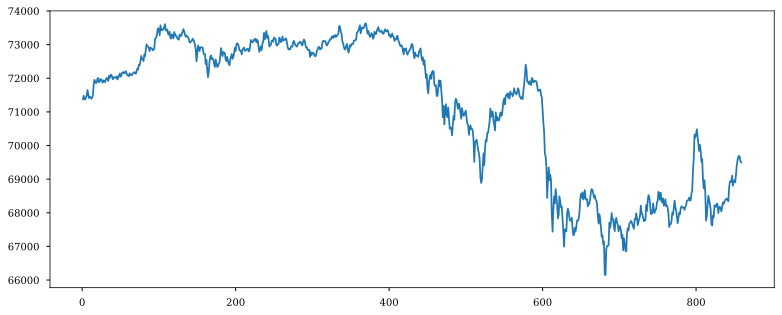

In [6]:
train_env.data['close'].plot(figsize=(13,5))

In [7]:
test_env = Finance(ticker, interval, features,
                 lags, min_performance=train_env.min_performance,
                 start=START_TEST, end=END_TEST)

Progress |██████████████████████████████████████████████████| 100% Complete
Successfully added rsi to DataFrame
Successfully added volatility to DataFrame
Successfully added volumeSma to DataFrame
Successfully added forceIndex to DataFrame
                   date      open      high       low     close     volume  \
0   2024-03-16 00:05:00  69570.00  69900.00  69569.99  69884.65  350.35090   
1   2024-03-16 00:10:00  69884.64  69955.84  69726.12  69772.00  216.38590   
2   2024-03-16 00:15:00  69772.00  70034.45  69752.00  69927.55  244.97016   
3   2024-03-16 00:20:00  69927.56  70043.00  69863.00  69863.01  197.94665   
4   2024-03-16 00:25:00  69863.00  69984.76  69786.17  69912.85  139.83034   
..                  ...       ...       ...       ...       ...        ...   
282 2024-03-16 23:35:00  65567.99  65709.99  65429.59  65606.03  402.07410   
283 2024-03-16 23:40:00  65606.03  65740.00  65560.00  65592.00  239.60600   
284 2024-03-16 23:45:00  65592.00  65620.00  65190.00  653

In [8]:
hu = max(lags, 24) # hidden_units
lr = 0.0001 # learing_rate
batch = True
agent = DQLAgent(hu, lr, batch, train_env, test_env)
print('Done')


Done


In [9]:
agent.value_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 24)            2784      
                                                                 
 lstm_1 (LSTM)               (None, 12)                1776      
                                                                 
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 2)                 26        
                                                                 
Total params: 4742 (18.52 KB)
Trainable params: 4742 (18.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
episodes = 12
%time agent.learn(episodes)

['rsi', 'volatility', 'volumeSma', 'forceIndex']

episode:   1/12  | loss: 0.02826 | perf:  11.161% | endurance:  849 | total reward:  10.07 | epsilon: 0.98
['rsi', 'volatility', 'volumeSma', 'forceIndex']
episode:   2/12  | loss: 0.03643 | perf:   1.371% | endurance:  849 | total reward:   2.14 | epsilon: 0.96
['rsi', 'volatility', 'volumeSma', 'forceIndex']
episode:   3/12  | loss: 0.02825 | perf:   1.173% | endurance:  849 | total reward:   0.87 | epsilon: 0.94
['rsi', 'volatility', 'volumeSma', 'forceIndex']
episode:   4/12  | loss: 0.02785 | perf:  -0.891% | endurance:  849 | total reward:   0.35 | epsilon: 0.92
['rsi', 'volatility', 'volumeSma', 'forceIndex']
episode:   5/12  | loss: 0.02562 | perf:  -4.490% | endurance:  849 | total reward:  -5.07 | epsilon: 0.9
['rsi', 'volatility', 'volumeSma', 'forceIndex']
episode:   6/12  | loss: 0.02922 | perf: -16.945% | endurance:  849 | total reward: -17.92 | epsilon: 0.89
['rsi', 'volatility', 'volumeSma', 'forceIndex']
episode:   7/12

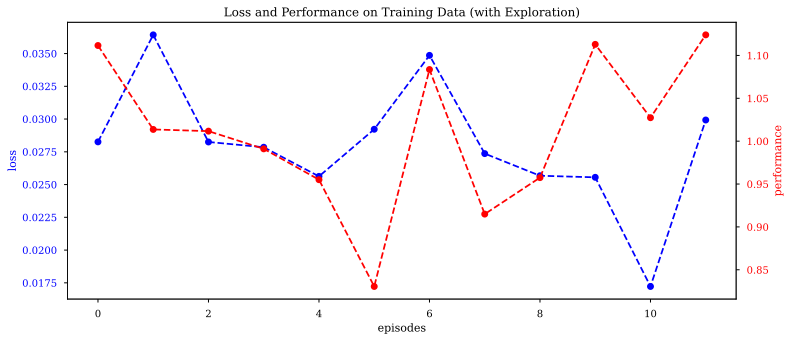

In [11]:
# Create a figure and the first y-axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Data for the first y-axis
x = range(1, len(agent.losses) + 1)
#y = np.polyval(np.polyfit(x, agent.losses, deg=3), x)
ax1.plot(agent.losses, 'bo--', label='loss')
ax1.set_xlabel('episodes')
ax1.set_ylabel('loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Data for the second y-axis
ax2.plot(agent.performances, 'ro--', label='performance')
ax2.set_ylabel('performance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Loss and Performance on Training Data (with Exploration)')
plt.show()

In [12]:
actions = []
length = len(test_env.data) - test_env.lags  
# Length is total data points minus the lookback period  

for i in range(length):

    state = test_env.reset(shift=i)  
    # Get state starting at shift point i
    
    state = np.reshape(state, [1, test_env.lags, test_env.n_features])  
    # Reshape state to match network input shape
    
    action = agent.value_model.predict(state, verbose=0)[0] 
    # Get action prediction
    
    if i%10==0:
        print(f'progress: {i:>4d}/{length:>4d}', end='\r')  
        # Print progress
   
    actions.append(np.argmax(action))
    # Save best action 

data = pd.DataFrame({
  'date' : test_env.data['date'].tail(length).reset_index(drop=True),
  'close' : test_env.data['close'].tail(length).reset_index(drop=True), 
  'log-ret-ns': test_env.data['log-ret-no-scale'].tail(length).reset_index(drop=True),
  'action': actions  
})
# Construct dataframe with returns and actions

data['action'].replace(0, -1, inplace=True)  
# Map action 0 to -1

data['performance'] = (data['log-ret-ns'] * data['action']).cumsum().apply(lambda x: np.exp(x))
# Get portfolio performance 

# paramters to save
buy_and_hold = (data['close'].iloc[-1] / data['close'].iloc[0] - 1) * 100  
perf_on_test = ((data['performance'].iloc[-1]-1) * 100)

text = 'Buy-and-hold strategy: {:4.1f}% \n' 
text += 'DRL strategy out of sample: {:4.1f}%'
print(text.format(buy_and_hold, perf_on_test))

Buy-and-hold strategy: -6.5% 
DRL strategy out of sample: -4.3%


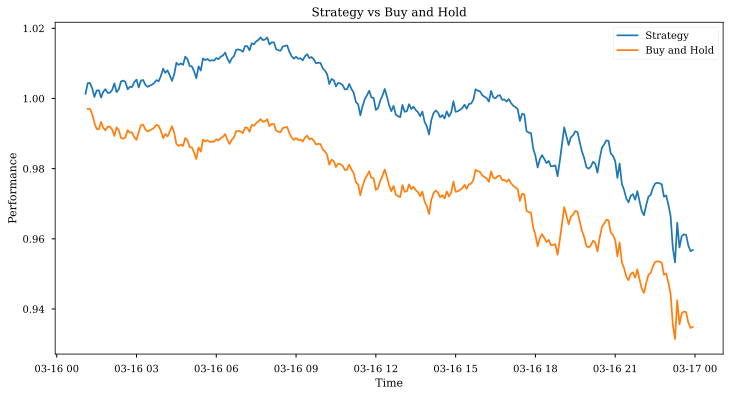

In [13]:
# Plot performance vs buy-and-hold strategy 
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['performance'], label='Strategy')
plt.plot(data['date'], data['close'].pct_change().apply(lambda x : x+1).cumprod(), label='Buy and Hold')
plt.title('Strategy vs Buy and Hold')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()

#### Visualize entry and exit points

In [14]:
#display figure
chart = visualize(data)
chart

alt.LayerChart(...)

In [15]:
# save figure
figname = 'filename-goes-here.html'
chart.save(figname)

#### Save parameters to file

In [16]:
filename = 'filename-goes-here.csv'
comment = 'add you comment here'
# Append the parameters to the file
save_params(filename, ticker, test_env.features, lags, episodes, lr, 
            agent.tau, agent.gamma, agent.epsilon_decay, buy_and_hold, perf_on_test, comment)